In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import matplotlib as mpl
import h5py

import sys
sys.path.append("../../../../fancy")
from fancy.plotting.colours import grey, purple, lightblue

In [2]:
mpl.rcParams['figure.dpi'] = 400
plt.style.use("minimalist_usetex")
font_size = 20

## 1. Skymaps with data and sources

In [3]:
from fancy.plotting import AllSkyMapCartopy
from fancy.interfaces import Data
from fancy.interfaces.stan import Direction
from fancy.plotting.colours import lightblue, midblue, darkblue, lightgrey, grey
from fancy.detector.exposure import m_dec

In [4]:
def gal_to_eq(glon, glat, ra_NGP=192.8583, dec_NGP=27.1283, glon_NCP=122.932):
    """Convert from galactic coordinates to J2000.0 equatorial coordinates"""
    # convert to radians
    glon_diff_rad = np.deg2rad(glon_NCP - glon)
    glat_rad = np.deg2rad(glat)
    dec_NGP_rad = np.deg2rad(dec_NGP)

    # get declination first
    sin_dec = np.sin(dec_NGP_rad) * np.sin(glat_rad) + np.cos(dec_NGP_rad) * np.cos(
        glat_rad
    ) * np.cos(glon_diff_rad)
    dec = np.rad2deg(np.arcsin(sin_dec))

    # get right ascension
    sin_ra_diff = np.cos(glat_rad) * np.sin(glon_diff_rad)
    cos_ra_diff = np.cos(dec_NGP_rad) * np.sin(glat_rad) - np.sin(dec_NGP_rad) * np.cos(
        glat_rad
    ) * np.cos(glon_diff_rad)

    ra = np.rad2deg(np.arctan2(sin_ra_diff, cos_ra_diff)) + ra_NGP

    return ra, dec


def gals_to_eqs(glons, glats, ra_NGP=192.8583, dec_NGP=27.1283, glon_NCP=122.932):
    """Vectorized version of gal -> eq coordinates"""
    return np.vectorize(gal_to_eq, excluded=[2, 3, 4])(
        glons, glats, ra_NGP, dec_NGP, glon_NCP
    )


def m_decs(decs, p):
    return np.vectorize(m_dec, excluded=[1])(decs, p)

In [5]:
uhecr_file = "../../data/UHECRdata.h5"
source_file = "../../data/sourcedata.h5"
num_points = 200
detector_labels = {
    "TA2015":"TA",
    "auger2014":"Auger",
    "auger2010":"Auger (2010)",
}
source_type = "SBG_23"
source_label = "Starburst galaxies"

### TA

In [6]:
from fancy.detector.TA2015 import detector_properties, detector_params

In [7]:
detector_type = "TA2015"

In [8]:
glons = np.linspace(0, 360, num_points)
glats = np.linspace(-90, 90, num_points)

glons_grid, glats_grid = np.meshgrid(glons, glats)

# convert to declination
_, decs_grid = gals_to_eqs(glons_grid, glats_grid)

# get exposure factor
m_full = m_decs(np.deg2rad(decs_grid), detector_params)
exposure_factor = m_full / np.max(m_full)

# plotting information for exposure
exp_cmap = colors.LinearSegmentedColormap.from_list(
    "custom",
    [lightgrey, grey],
    N=6,
)
exp_norm_proj = colors.Normalize(exposure_factor.min(), exposure_factor.max())

In [9]:
data = Data()
data.add_uhecr(uhecr_file, detector_type)
data.add_detector(detector_properties)
data.add_source(source_file, source_type)

source_direction = Direction(data.source.unit_vector)
arrival_direction = Direction(data.uhecr.unit_vector)
energy = data.uhecr.energy

# plotting info for UHECRs
uhecr_color = [lightblue, midblue, darkblue]
uhecr_cmap = mpl.colors.ListedColormap(uhecr_color)
energy_bins = np.logspace(np.log(57), np.log(170), 4, base=np.e)
uhecr_norm = mpl.colors.BoundaryNorm(energy_bins, uhecr_cmap.N)

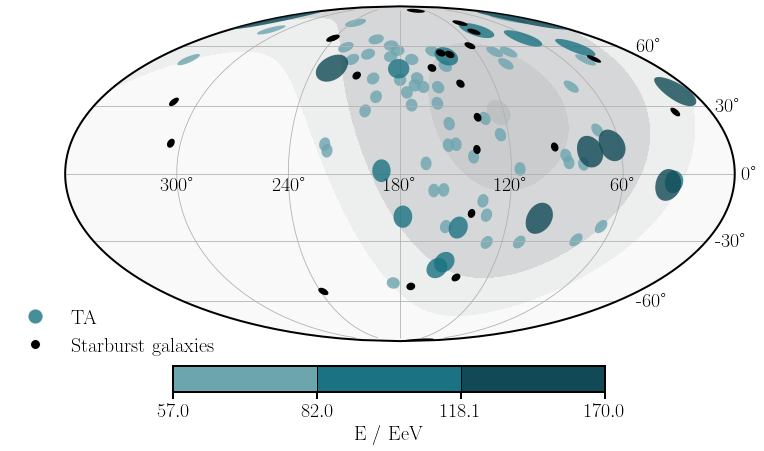

In [10]:
skymap = AllSkyMapCartopy(lon_0=180.)
skymap.set_gridlines(ypadding=10., fontsize=font_size)

# exposure factor
skymap.ax.contourf(
    glons_grid,
    glats_grid,
    exposure_factor,
    cmap=exp_cmap,
    norm=exp_norm_proj,
    levels=np.linspace(0, 1, 6),
    transform=skymap.transform,
)

# Sources
for lon, lat in np.nditer([source_direction.glons, source_direction.glats]):
    skymap.tissot(lon, lat, 2.0, npts=30, facecolor="k", alpha=1.0, zorder=5)

# UHECRs
for lon, lat, E in np.nditer(
    [arrival_direction.glons, arrival_direction.glats, energy]):
    i = np.digitize(E, energy_bins) - 1
    skymap.tissot(
        lon,
        lat,
        3.0 + (i * 2),
        npts=30,
        lw=0,
        color=uhecr_cmap.colors[i],
        alpha=0.8,
        zorder=i + 2,
    )

# legend
handles = [
    mpl.lines.Line2D([0], [0],
                     marker="o",
                     color="w",
                     label=detector_labels[detector_type],
                     markersize=15,
                     markerfacecolor=midblue,
                     alpha=0.8), 
    mpl.lines.Line2D([0], [0],
                     marker="o",
                     color="w",
                     label=source_label,
                     markersize=10,
                     markerfacecolor="k",
                     alpha=1.0)
]

skymap.ax.legend(
    handles=handles,
    bbox_to_anchor=(0.25, 0.15),
    fontsize=font_size,
    fancybox=False,
    frameon=False,
)

# colorbar
cax = plt.axes([0.25, 0.07, .5, .05], frameon=True)
bar = mpl.colorbar.ColorbarBase(
    cax,
    norm=uhecr_norm,
    cmap=uhecr_cmap,
    orientation='horizontal',
    drawedges=True,
    alpha=1,
)
bar.set_label("E / EeV", color='k', fontsize=font_size)
bar.ax.tick_params(labelsize=font_size)

# save figure
skymap.fig.savefig(
    f"figures/data_source_skymap_{detector_type}.pdf",
    bbox_inches='tight',
    dpi=400,
)

### Auger

In [11]:
from fancy.detector.auger2014 import detector_properties, detector_params

In [12]:
detector_type = "auger2014"

In [13]:
glons = np.linspace(0, 360, num_points)
glats = np.linspace(-90, 90, num_points)

glons_grid, glats_grid = np.meshgrid(glons, glats)

# convert to declination
_, decs_grid = gals_to_eqs(glons_grid, glats_grid)

# get exposure factor
m_full = m_decs(np.deg2rad(decs_grid), detector_params)
exposure_factor = m_full / np.max(m_full)

# plotting information for exposure
exp_cmap = colors.LinearSegmentedColormap.from_list(
    "custom",
    [lightgrey, grey],
    N=6,
)
exp_norm_proj = colors.Normalize(exposure_factor.min(), exposure_factor.max())

In [14]:
data = Data()
data.add_uhecr(uhecr_file, detector_type)
data.add_detector(detector_properties)
data.add_source(source_file, source_type)

source_direction = Direction(data.source.unit_vector)
arrival_direction = Direction(data.uhecr.unit_vector)
energy = data.uhecr.energy

# plotting info for UHECRs
uhecr_color = [lightblue, midblue, darkblue]
uhecr_cmap = mpl.colors.ListedColormap(uhecr_color)
energy_bins = np.logspace(np.log(52), np.log(150), 4, base=np.e)
uhecr_norm = mpl.colors.BoundaryNorm(energy_bins, uhecr_cmap.N)

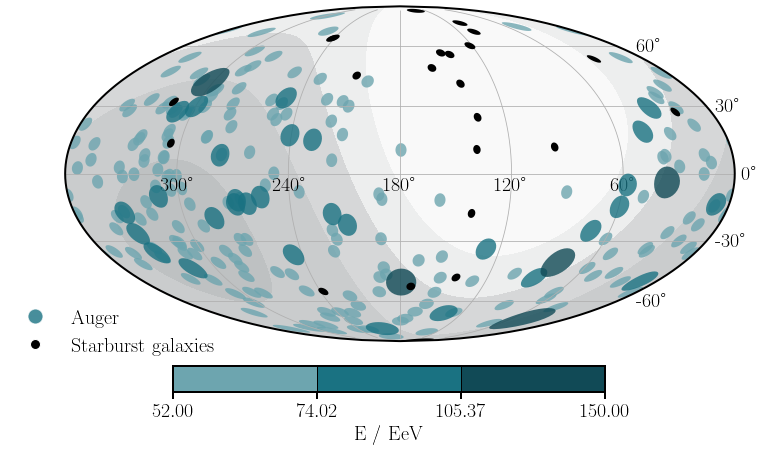

In [15]:
skymap = AllSkyMapCartopy(lon_0=180.)
skymap.set_gridlines(ypadding=10., fontsize=font_size)

# exposure factor
skymap.ax.contourf(
    glons_grid,
    glats_grid,
    exposure_factor,
    cmap=exp_cmap,
    norm=exp_norm_proj,
    levels=np.linspace(0, 1, 6),
    transform=skymap.transform,
)

# Sources
for lon, lat in np.nditer([source_direction.glons, source_direction.glats]):
    skymap.tissot(lon, lat, 2.0, npts=30, facecolor="k", alpha=1.0, zorder=5)

# UHECRs
for lon, lat, E in np.nditer(
    [arrival_direction.glons, arrival_direction.glats, energy]):
    i = np.digitize(E, energy_bins) - 1
    skymap.tissot(
        lon,
        lat,
        3.0 + (i * 2),
        npts=30,
        lw=0,
        color=uhecr_cmap.colors[i],
        alpha=0.8,
        zorder=i + 2,
    )

# legend
handles = [
    mpl.lines.Line2D([0], [0],
                     marker="o",
                     color="w",
                     label=detector_labels[detector_type],
                     markersize=15,
                     markerfacecolor=midblue,
                     alpha=0.8), 
    mpl.lines.Line2D([0], [0],
                     marker="o",
                     color="w",
                     label=source_label,
                     markersize=10,
                     markerfacecolor="k",
                     alpha=1.0)
]

skymap.ax.legend(
    handles=handles,
    bbox_to_anchor=(0.25, 0.15),
    fontsize=font_size,
    fancybox=False,
    frameon=False,
)

# colorbar
cax = plt.axes([0.25, 0.07, .5, .05], frameon=True)
bar = mpl.colorbar.ColorbarBase(
    cax,
    norm=uhecr_norm,
    cmap=uhecr_cmap,
    orientation='horizontal',
    drawedges=True,
    alpha=1,
)
bar.set_label("E / EeV", color='k', fontsize=font_size)
bar.ax.tick_params(labelsize=font_size)

# save figure
skymap.fig.savefig(
    f"figures/data_source_skymap_{detector_type}.pdf",
    bbox_inches='tight',
    dpi=400,
)

## 2. Associated fraction results 

In [4]:
import os
from scipy.stats import gaussian_kde

from fancy.analysis import Results

In [5]:
results_dir = "../energy_loss/output/"

results_file_TA_p_joint = os.path.join(results_dir, "outputs_joint/joint_fit_SBG23_TA2015_None_p_19990308_Lloss_tightB.h5")
results_file_TA_N_joint = os.path.join(results_dir, "outputs_joint/joint_fit_SBG23_TA2015_None_N_19990308_Lloss_tightB.h5")

results_file_auger_p_joint = os.path.join(results_dir, "outputs_joint/joint_fit_SBG23_auger2014_None_p_19990308_Lloss_tightB.h5")
results_file_auger_N_joint = os.path.join(results_dir, "outputs_joint/joint_fit_SBG23_auger2014_None_N_19990308_Lloss_tightB.h5")

results_file_TA_p_joint_gmf = os.path.join(results_dir, "outputs_jointGMF/jointGMF_fit_SBG23_TA2015_JF12_p_19990308_Lloss_tightB.h5")
results_file_TA_N_joint_gmf = os.path.join(results_dir, "outputs_jointGMF/jointGMF_fit_SBG23_TA2015_JF12_N_19990308_Lloss_tightB.h5")

results_file_auger_p_joint_gmf = os.path.join(results_dir, "outputs_jointGMF/jointGMF_fit_SBG23_auger2014_JF12_p_19990308_Lloss_tightB.h5")
results_file_auger_N_joint_gmf = os.path.join(results_dir, "outputs_jointGMF/jointGMF_fit_SBG23_auger2014_JF12_N_19990308_Lloss_tightB.h5")

In [6]:
f_results_TA_p_joint = Results(results_file_TA_p_joint).get_chain(["f"])["f"]
f_results_TA_N_joint = Results(results_file_TA_N_joint).get_chain(["f"])["f"]

f_results_auger_p_joint = Results(results_file_auger_p_joint).get_chain(["f"])["f"]
f_results_auger_N_joint = Results(results_file_auger_N_joint).get_chain(["f"])["f"]

f_results_TA_p_joint_gmf = Results(results_file_TA_p_joint_gmf).get_chain(["f"])["f"]
f_results_TA_N_joint_gmf = Results(results_file_TA_N_joint_gmf).get_chain(["f"])["f"]

f_results_auger_p_joint_gmf = Results(results_file_auger_p_joint_gmf).get_chain(["f"])["f"]
f_results_auger_N_joint_gmf = Results(results_file_auger_N_joint_gmf).get_chain(["f"])["f"]

In [7]:
kde_kws = {'shade': True, 'lw': 2, 'zorder': 0}

In [8]:
results_list_TA = [f_results_TA_p_joint, f_results_TA_p_joint_gmf, f_results_TA_N_joint, f_results_TA_N_joint_gmf]
results_list_auger = [f_results_auger_p_joint, f_results_auger_p_joint_gmf, f_results_auger_N_joint, f_results_auger_N_joint_gmf]
results_labels = ["Proton", "Proton + GMF", "Nitrogen", "Nitrogen + GMF"]

In [126]:
colors = plt.get_cmap("viridis_r")(np.linspace(0.3, 1.0, 4))
edge_colors = colors.copy()
face_colors = colors
for fc in face_colors:
    fc[-1] = 0.3
edge_colors

array([[0.266941, 0.748751, 0.440573, 1.      ],
       [0.139147, 0.533812, 0.555298, 1.      ],
       [0.239346, 0.300855, 0.540844, 1.      ],
       [0.267004, 0.004874, 0.329415, 1.      ]])

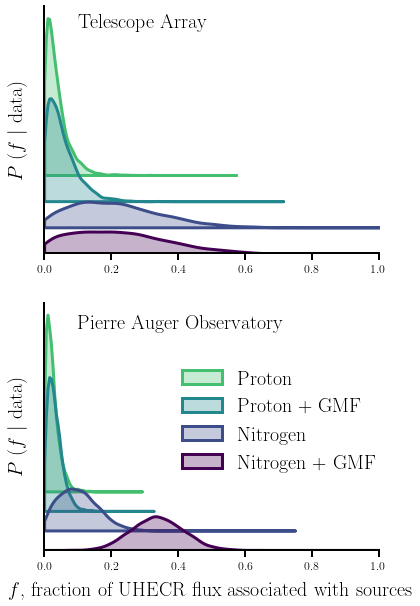

In [132]:
x = np.linspace(0, 1, 200)
offset = 3

fig, ax = plt.subplots(2, 1)
fig. set_size_inches((6, 10))
y_offset = 20
for i, result in enumerate(results_list_TA):
    y_vals = gaussian_kde(result, bw_method=0.2)(x)
    idx = y_vals > 0.0
    ax[0].fill_between(x[idx], y_offset, y_vals[idx] + y_offset, lw=3, facecolor=face_colors[i], edgecolor=edge_colors[i], label=results_labels[i])
    y_offset -= offset
ax[0].text(0.1, 37, "Telescope Array", fontsize=font_size)
#ax[0].legend(fontsize=font_size, bbox_to_anchor=(0.45, 0.75))

y_offset = 20
for i, result in enumerate(results_list_auger):
    y_vals = gaussian_kde(result, bw_method=0.2)(x)
    idx = y_vals > 0.0
    ax[1].fill_between(x[idx], y_offset, y_vals[idx] + y_offset, lw=3, facecolor=face_colors[i], edgecolor=edge_colors[i], label=results_labels[i])
    y_offset -= offset

ax[1].text(0.1, 45, "Pierre Auger Observatory", fontsize=font_size)
ax[1].legend(fontsize=font_size, bbox_to_anchor=(1.05, 0.8))
ax[1].set_xlabel("$f$, fraction of UHECR flux associated with sources", fontsize=font_size, labelpad=10)

for axis in ax:
    axis.set_ylabel("$P~(f~|~\mathrm{data})$", fontsize=font_size, labelpad=10)
    axis.get_yaxis().set_ticks([])
    axis.set_ylim(11)

fig.savefig("figures/associated_fraction_comp.pdf", dpi=400)

## 3. Individual association skymap

In [98]:
from fancy.plotting import AllSkyMapCartopy
from fancy.interfaces import Data
from fancy.interfaces.stan import Direction
from fancy.plotting.colours import lightblue, midblue, darkblue, lightgrey, grey

In [99]:
uhecr_file = "../../data/UHECRdata.h5"
source_file = "../../data/sourcedata.h5"
num_points = 200
detector_labels = {
    "TA2015":"TA",
    "auger2014":"Auger",
    "auger2010":"Auger (2010)",
}
source_type = "SBG_23"
source_label = "Starburst galaxies"

highlight_color = "#C94045"
arrowprops = {}
arrowprops["arrowstyle"] = "-"
arrowprops["linewidth"] = 2
arrowprops["color"] = highlight_color

### TA

In [100]:
from fancy.detector.TA2015 import detector_properties, detector_params

In [101]:
detector_type = "TA2015"
results_file = results_file_TA_N_joint_gmf

In [102]:
data = Data()
data.add_uhecr(uhecr_file, detector_type)
data.add_detector(detector_properties)
data.add_source(source_file, source_type)

source_direction = Direction(data.source.unit_vector)
arrival_direction = Direction(data.uhecr.unit_vector)
energy = data.uhecr.energy

# plotting info for UHECRs
uhecr_color = [lightblue, midblue, darkblue]
uhecr_cmap = mpl.colors.ListedColormap(uhecr_color)
energy_bins = np.logspace(np.log(57), np.log(170), 4, base=np.e)
uhecr_norm = mpl.colors.BoundaryNorm(energy_bins, uhecr_cmap.N)

In [103]:
# get log probability
logprob = Results(results_file).get_chain(["lp"])["lp"].transpose(1, 2, 0)

N_uhecr = np.shape(logprob)[0]  # number of UHECRs
Ns = np.shape(logprob)[1] - 1  # number of sources

# Calculate association probabilities for each source-UHECR combo
uhecr_p = []
for lp in logprob:
    lps = []
    for src in range(Ns + 1):
        lps.append(np.mean(np.exp(lp[src])))

    norm = sum(lps)
    ps = []
    for src in range(Ns + 1):
        ps.append(lps[src] / norm)
    uhecr_p.append(ps)

# Normalise line weights
pmax = np.max(uhecr_p)
threshold_probability = 0.1

dominant = []
for p in uhecr_p:
    for i in range(data.source.N):
        if p[i] > threshold_probability:
            dominant.append(i)

seen = set()
inds = []
for d in dominant:
    if d not in seen:
        inds.append(d)
        seen.add(d)
print("Dominant sources: ", [data.source.name[i] for i in inds])

textloc_srcs = [(30, -10), (-90, 5)]

Dominant sources:  [b'NGC6946', b'M82', b'IC342', b'M83', b'NGC253']


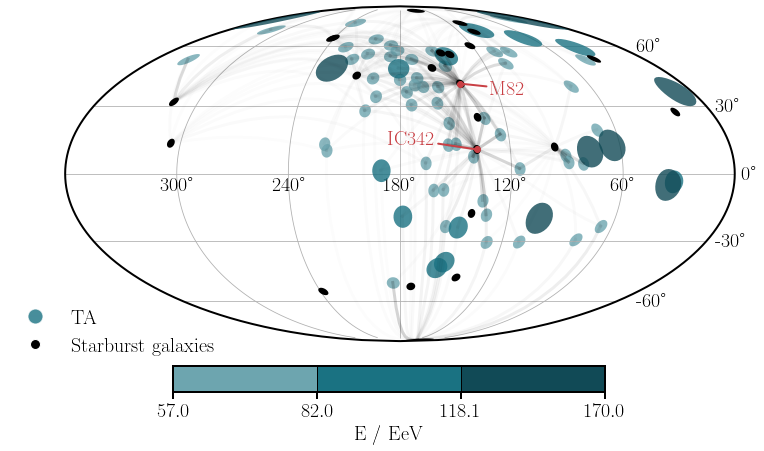

In [104]:
skymap = AllSkyMapCartopy(lon_0=180.)
skymap.set_gridlines(ypadding=10., fontsize=font_size)

transform_ax = skymap.transform._as_mpl_transform(skymap.ax)

# Sources
for lon, lat in np.nditer([source_direction.glons, source_direction.glats]):
    skymap.tissot(lon, lat, 2.0, npts=30, facecolor="k", alpha=1.0, zorder=5)
for j, i in enumerate(inds[1:3]):
    skymap.scatter(source_direction.glons[i], source_direction.glats[i], color=highlight_color, zorder=100)
    skymap.ax.annotate(data.source.name[i].decode("ascii"), 
                    (source_direction.glons[i], source_direction.glats[i]), 
                    xycoords=transform_ax, zorder=99,
                    textcoords="offset points", xytext=textloc_srcs[j], fontsize=font_size,
                    arrowprops=arrowprops, color=highlight_color, weight="bold")

# UHECRs
for lon, lat, E in np.nditer(
    [arrival_direction.glons, arrival_direction.glats, energy]):
    i = np.digitize(E, energy_bins) - 1
    skymap.tissot(
        lon,
        lat,
        3.0 + (i * 2),
        npts=30,
        lw=0,
        color=uhecr_cmap.colors[i],
        alpha=0.8,
        zorder=i + 2,
    )

# Association
for i, p in enumerate(uhecr_p):
    for j, psrc in enumerate(p[0:Ns]):
        if psrc > 0.01:
            skymap.geodesic(
                arrival_direction.glons[i],
                arrival_direction.glats[i],
                source_direction.glons[j],
                source_direction.glats[j],
                color='k',
                lw=3,
                alpha=psrc / pmax,
                zorder=10,
            )

# legend
handles = [
    mpl.lines.Line2D([0], [0],
                     marker="o",
                     color="w",
                     label=detector_labels[detector_type],
                     markersize=15,
                     markerfacecolor=midblue,
                     alpha=0.8), 
    mpl.lines.Line2D([0], [0],
                     marker="o",
                     color="w",
                     label=source_label,
                     markersize=10,
                     markerfacecolor="k",
                     alpha=1.0)
]

skymap.ax.legend(
    handles=handles,
    bbox_to_anchor=(0.25, 0.15),
    fontsize=font_size,
    fancybox=False,
    frameon=False,
)

# colorbar
cax = plt.axes([0.25, 0.07, .5, .05], frameon=True)
bar = mpl.colorbar.ColorbarBase(
    cax,
    norm=uhecr_norm,
    cmap=uhecr_cmap,
    orientation='horizontal',
    drawedges=True,
    alpha=1,
)
bar.set_label("E / EeV", color='k', fontsize=font_size)
bar.ax.tick_params(labelsize=font_size)

# save figure
skymap.fig.savefig(
    f"figures/association_skymap_{detector_type}.pdf",
    bbox_inches='tight',
    dpi=400,
)

### Auger

In [92]:
from fancy.detector.auger2014 import detector_properties, detector_params

In [93]:
detector_type = "auger2014"
results_file = results_file_auger_N_joint_gmf

In [94]:
data = Data()
data.add_uhecr(uhecr_file, detector_type)
data.add_detector(detector_properties)
data.add_source(source_file, source_type)

source_direction = Direction(data.source.unit_vector)
arrival_direction = Direction(data.uhecr.unit_vector)
energy = data.uhecr.energy

# plotting info for UHECRs
uhecr_color = [lightblue, midblue, darkblue]
uhecr_cmap = mpl.colors.ListedColormap(uhecr_color)
energy_bins = np.logspace(np.log(52), np.log(150), 4, base=np.e)
uhecr_norm = mpl.colors.BoundaryNorm(energy_bins, uhecr_cmap.N)

In [95]:
# get log probability
logprob = Results(results_file).get_chain(["lp"])["lp"].transpose(1, 2, 0)

N_uhecr = np.shape(logprob)[0]  # number of UHECRs
Ns = np.shape(logprob)[1] - 1  # number of sources

# Calculate association probabilities for each source-UHECR combo
uhecr_p = []
for lp in logprob:
    lps = []
    for src in range(Ns + 1):
        lps.append(np.mean(np.exp(lp[src])))

    norm = sum(lps)
    ps = []
    for src in range(Ns + 1):
        ps.append(lps[src] / norm)
    uhecr_p.append(ps)

# Normalise line weights
pmax = np.max(uhecr_p)
threshold_probability = 0.1

dominant = []
for p in uhecr_p:
    for i in range(data.source.N):
        if p[i] > threshold_probability:
            dominant.append(i)

seen = set()
inds = []
for d in dominant:
    if d not in seen:
        inds.append(d)
        seen.add(d)
print("Dominant sources: ", [data.source.name[i] for i in inds])
textloc_srcs = [(-100, 30), (100, -10), (-130, -150)]

Dominant sources:  [b'M83', b'NGC253', b'NGC4945', b'NGC5055']


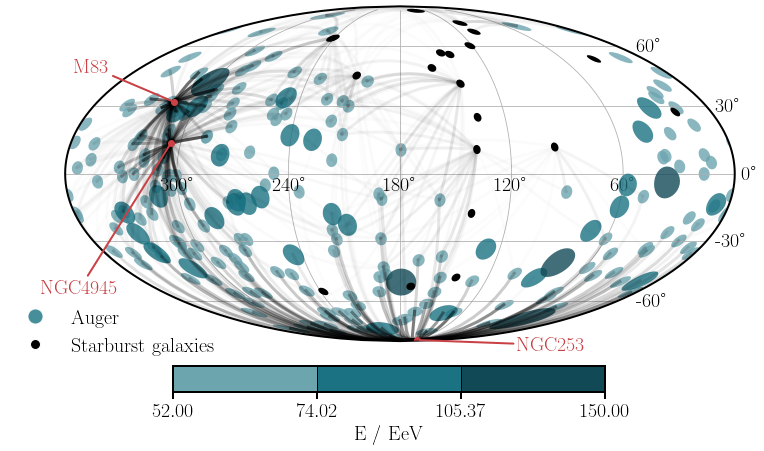

In [97]:
skymap = AllSkyMapCartopy(lon_0=180.)
skymap.set_gridlines(ypadding=10., fontsize=font_size)

transform_ax = skymap.transform._as_mpl_transform(skymap.ax)

# Sources
for lon, lat in np.nditer([source_direction.glons, source_direction.glats]):
    skymap.tissot(lon, lat, 2.0, npts=30, facecolor="k", alpha=1.0, zorder=5)
for j, i in enumerate(inds[0:3]):
    skymap.scatter(source_direction.glons[i], source_direction.glats[i], color=highlight_color, zorder=100)
    skymap.ax.annotate(data.source.name[i].decode("ascii"), 
                    (source_direction.glons[i], source_direction.glats[i]), 
                    xycoords=transform_ax, zorder=99, color=highlight_color,
                    textcoords="offset points", xytext=textloc_srcs[j], fontsize=font_size,
                    arrowprops=arrowprops, weight="bold")

# UHECRs
for lon, lat, E in np.nditer(
    [arrival_direction.glons, arrival_direction.glats, energy]):
    i = np.digitize(E, energy_bins) - 1
    skymap.tissot(
        lon,
        lat,
        3.0 + (i * 2),
        npts=30,
        lw=0,
        color=uhecr_cmap.colors[i],
        alpha=0.8,
        zorder=i + 2,
    )


# Association
for i, p in enumerate(uhecr_p):
    for j, psrc in enumerate(p[0:Ns]):
        if psrc > 0.01:
            skymap.geodesic(
                arrival_direction.glons[i],
                arrival_direction.glats[i],
                source_direction.glons[j],
                source_direction.glats[j],
                color='k',
                lw=3,
                alpha=psrc / pmax,
                zorder=10,
            )

# legend
handles = [
    mpl.lines.Line2D([0], [0],
                     marker="o",
                     color="w",
                     label=detector_labels[detector_type],
                     markersize=15,
                     markerfacecolor=midblue,
                     alpha=0.8), 
    mpl.lines.Line2D([0], [0],
                     marker="o",
                     color="w",
                     label=source_label,
                     markersize=10,
                     markerfacecolor="k",
                     alpha=1.0)
]

skymap.ax.legend(
    handles=handles,
    bbox_to_anchor=(0.25, 0.15),
    fontsize=font_size,
    fancybox=False,
    frameon=False,
)

# colorbar
cax = plt.axes([0.25, 0.07, .5, .05], frameon=True)
bar = mpl.colorbar.ColorbarBase(
    cax,
    norm=uhecr_norm,
    cmap=uhecr_cmap,
    orientation='horizontal',
    drawedges=True,
    alpha=1,
)
bar.set_label("E / EeV", color='k', fontsize=font_size)
bar.ax.tick_params(labelsize=font_size)

# save figure
skymap.fig.savefig(
    f"figures/association_skymap_{detector_type}.pdf",
    bbox_inches='tight',
    dpi=400,
)